In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='notebook',
    # font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
import datashader as ds
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as dstf

In [3]:
print(np.__version__)
print(pd.__version__)

1.22.3
1.4.2


In [4]:
os.chdir('../')

In [123]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
from rlmolecule.crystal.crystal_state import CrystalState
from rlmolecule.crystal.crystal_reward import StructureRewardBattInterface
from rlmolecule.crystal import ehull
from rlmolecule.crystal.ehull import fere_entries

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


2022-07-15 12:25:43.315213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-07-15 12:25:43.315244: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
INFO:rdkit:Enabling RDKit 2022.03.2 jupyter extensions


In [43]:
rewards_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/best_decor_rewards.csv.gz"
pred_df = pd.read_csv(rewards_file)
print(len(pred_df))
pred_df.head(2)

2003


,id,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
0,Li3Y1Br6_icsd_053533_1,Li3Y1Br6,1.135173,-3.798492,-0.8512,0.3000,-0.6734,-5.0,4.3266
1,Li4Y1Br7_icsd_001322_1,Li4Y1Br7,1.132112,-3.735198,-0.7266,0.3333,-0.6045,-5.0,4.3955


In [7]:
dft_file = "/projects/rlmolecule/pgorai/dft_validation_07102022/dft_valid_07102022.csv"
dft_data = pd.read_csv(dft_file)
print(len(dft_data))
dft_data.head(2)

1486


,decoration,numatoms,relaxedvolume,energyperatom
0,K2Hf1W3N8/K2Hf1W3N8_icsd_020114_1,28,564.05,-8.203
1,Li4Y2Br8O1/Li4Y2Br8O1_icsd_002330_1,30,781.97,-4.245


In [8]:
dft_data['id'] = dft_data.decoration.apply(lambda x: x.split('/')[1])
dft_data.set_index('id', inplace=True)

In [9]:
def extract_id(decorated_str):
    decor_split = decorated_str.split('|')
    out_str = '_'.join([decor_split[0], decor_split[3].replace('POSCAR_',''), decor_split[4]])
    return out_str

In [46]:
# pred_df['id'] = pred_df.decor_id.apply(extract_id)
pred_df.set_index('id', inplace=True)

In [47]:
dft_data['predicted_energy'] = pred_df['predicted_energy']
dft_data['predicted_decomp'] = pred_df['decomp_energy']
dft_data['energy_err'] = dft_data['predicted_energy'] - dft_data['energyperatom']
print(dft_data['energy_err'].mean())
dft_data.head(2)

0.15071393515251846


,decoration,numatoms,relaxedvolume,energyperatom,predicted_energy,predicted_decomp,energy_err,comp,id,decomp_energy
id,,,,,,,,,,
K2Hf1W3N8_icsd_020114_1,K2Hf1W3N8/K2Hf1W3N8_icsd_020114_1,28,564.05,-8.203,-8.082979,-0.1975,0.120021,K2Hf1W3N8,K2Hf1W3N8_icsd_020114_1,-0.317494
Li4Y2Br8O1_icsd_002330_1,Li4Y2Br8O1/Li4Y2Br8O1_icsd_002330_1,30,781.97,-4.245,-3.923797,-0.2844,0.321203,Li4Y2Br8O1,Li4Y2Br8O1_icsd_002330_1,-0.605567


In [179]:
dft_data.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,predicted_energy,predicted_decomp,energy_err,comp,decomp_energy
id,,,,,,,,,
K2Hf1W3N8_icsd_020114_1,K2Hf1W3N8/K2Hf1W3N8_icsd_020114_1,28,564.05,-8.203,-8.082979,-0.1975,0.120021,K2Hf1W3N8,-0.317494
Li4Y2Br8O1_icsd_002330_1,Li4Y2Br8O1/Li4Y2Br8O1_icsd_002330_1,30,781.97,-4.245,-3.923797,-0.2844,0.321203,Li4Y2Br8O1,-0.605567


In [180]:
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz/pred_vs_dft.csv"
dft_data.to_csv(out_file)

In [77]:
sns.set_style('ticks')

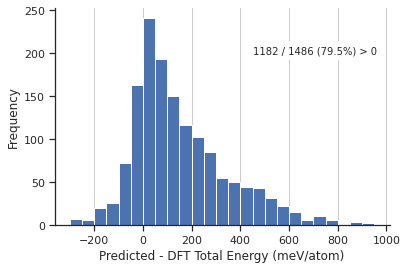

In [84]:
bins = np.arange(-.3, 1, .05) * 1000
ax = (dft_data.energy_err * 1000).plot.hist(bins=bins)
plt.xlabel("Predicted - DFT Total Energy (meV/atom)")
num_strcs = len(dft_data)
num_lower_energy = len(dft_data[dft_data['energy_err'] > 0])
perc_passing = num_lower_energy / num_strcs
plt.text(450, 200, 
         f"{num_lower_energy} / {num_strcs} ({perc_passing*100:0.1f}%) > 0",
         backgroundcolor='white',
        )

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
sns.despine()
ax.xaxis.grid(True)
# ax.spines['bottom'].set_visible(False)
# ax.set_xticks(np.arange(-400, 1100, 200))

In [54]:
print(len(dft_data[dft_data['energy_err'] > 0]))
print(len(dft_data[dft_data['energy_err'] > 0]) / len(dft_data))
print(len(dft_data[dft_data['energy_err'] > -.05]) / len(dft_data))

1182
0.7954239569313594
0.9071332436069987


<AxesSubplot:xlabel='energyperatom', ylabel='predicted_energy'>

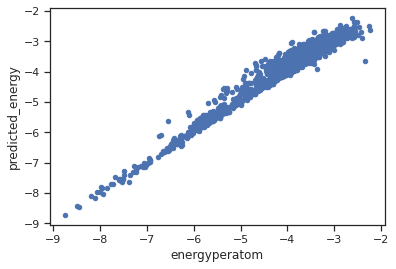

In [12]:
dft_data.plot.scatter('energyperatom', 'predicted_energy')

### Compute the decomposition energy for each of them

In [30]:
from pymatgen.core import Composition
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDEntry

In [27]:
def setup_competing_phases(competing_phases_files):
    if not isinstance(competing_phases_files, list):
        competing_phases_files = [competing_phases_files]
    all_competing_phases = [load_competing_phases(f) for f in competing_phases_files]

    # also add the individual elements
    competing_phases = pd.concat([pd.Series(fere_entries)] + all_competing_phases).reset_index()[0]
    return competing_phases


def load_competing_phases(competing_phases_file):
    print(f"Reading {competing_phases_file}")
    df = pd.read_csv(competing_phases_file)
    print(f"\t{len(df)} lines")
    print(df.head(2))

    assert ('sortedformula' in df.columns or 'comp' in df.columns) \
        and ('energyperatom' in df.columns or 'predicted_energy' in df.columns)
    if 'sortedformula' not in df.columns:
        df.rename(columns={'comp': 'sortedformula'}, inplace=True)
    if 'energyperatom' not in df.columns:
        df.rename(columns={'predicted_energy': 'energyperatom'}, inplace=True)
    print("columns after renaming:", df.columns)

    df['energy'] = (
        df.energyperatom *
        df.sortedformula.apply(lambda x: Composition(x).num_atoms)
    )
    # convert the dataframe to a list of PDEntries used to create the convex hull
    pd_entries = df.apply(
        lambda row: PDEntry(Composition(row.sortedformula),
                            row.energy),
        axis=1
    )
    print(f"\t{len(pd_entries)} entries")
    return pd_entries

In [111]:
competing_phases_files = [
    "/projects/rlmolecule/jlaw/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv",
    # "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/best_decor_rewards.csv.gz",
]

In [120]:
competing_phases = setup_competing_phases(competing_phases_files)

Reading /projects/rlmolecule/jlaw/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv
	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4
columns after renaming: Index(['sortedformula', 'icsdnum', 'energyperatom', 'reduced_composition'], dtype='object')
	12682 entries


In [20]:
dft_data['comp'] = dft_data.decoration.apply(lambda x: x.split('/')[0])
dft_data['id'] = dft_data.decoration.apply(lambda x: x.split('/')[1])
dft_data.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,predicted_energy,predicted_decomp,energy_err,comp,id
id,,,,,,,,,
K2Hf1W3N8_icsd_020114_1,K2Hf1W3N8/K2Hf1W3N8_icsd_020114_1,28,564.05,-8.203,-8.083,-0.022,0.120,K2Hf1W3N8,K2Hf1W3N8_icsd_020114_1
Li4Y2Br8O1_icsd_002330_1,Li4Y2Br8O1/Li4Y2Br8O1_icsd_002330_1,30,781.97,-4.245,-3.924,0.435,0.321,Li4Y2Br8O1,Li4Y2Br8O1_icsd_002330_1


In [36]:
def compute_decomp_energy(row, energy_col="energyperatom"):
    comp, energyperatom = Composition(row.comp), row[energy_col]
    decomp_energy, stability_window = ehull.convex_hull_stability(
            comp,
            energyperatom,
            competing_phases)

    return decomp_energy

In [37]:
dft_data['decomp_energy'] = dft_data.progress_apply(compute_decomp_energy, axis=1)

  0%|          | 0/1486 [00:00<?, ?it/s]

In [38]:
dft_data.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,predicted_energy,predicted_decomp,energy_err,comp,id,decomp_energy
id,,,,,,,,,,
K2Hf1W3N8_icsd_020114_1,K2Hf1W3N8/K2Hf1W3N8_icsd_020114_1,28,564.05,-8.203,-8.083,-0.022,0.120,K2Hf1W3N8,K2Hf1W3N8_icsd_020114_1,-0.317494
Li4Y2Br8O1_icsd_002330_1,Li4Y2Br8O1/Li4Y2Br8O1_icsd_002330_1,30,781.97,-4.245,-3.924,0.435,0.321,Li4Y2Br8O1,Li4Y2Br8O1_icsd_002330_1,-0.605567


In [94]:
print(len(dft_data[dft_data['decomp_energy'] < -.1]))
print(len(dft_data[dft_data['decomp_energy'] < -.1]) / len(dft_data))
print(len(dft_data[dft_data['decomp_energy'] < 0]))
print(len(dft_data[dft_data['decomp_energy'] < 0]) / len(dft_data))
print(len(dft_data[dft_data['decomp_energy'] < 0.05]))
print(len(dft_data))

1434
0.9650067294751009
1473
0.9912516823687753
1478
1486


In [176]:
viz_dir = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz"

/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz/pred_vs_dft_decomp_energy_combined.svg


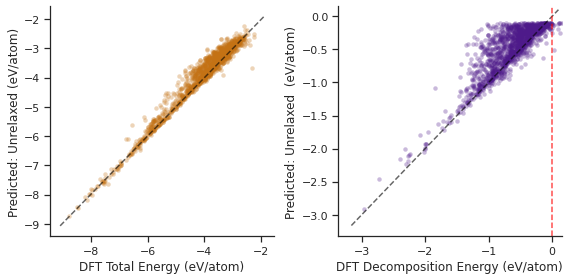

In [195]:
df = dft_data.copy()
f, (ax2, ax1) = plt.subplots(ncols=2, figsize=(8,4))

# ax1 = sns.scatterplot(data=df, ax=ax1,
ax1 = df.plot.scatter(ax=ax1,
                x='decomp_energy', y='predicted_decomp', 
                alpha=0.3, s=20, linewidth=0,
                      color="#4e1a8a",  # purple
                      # color="#c47214",  # orange
)
# ax1.plot([-1,0], [-1,0], ls='--', c='gray')
ax1.plot((ax1.get_xlim()[0], 0.1), 
         (ax1.get_xlim()[0], 0.1), 
         ls='--', c='black', alpha=0.6)
ax1.set_ylim(ymin=ax1.get_ylim()[0], ymax=0.15)
ax1.set_xlim(xmin=ax1.get_xlim()[0], xmax=0.15)
ax1.axvline(0, ls='--', c='red', alpha=0.7)
ax1.set_xlabel("DFT Decomposition Energy (eV/atom)")
ax1.set_ylabel("Predicted: Unrelaxed  (eV/atom)")
# ax1.set_title("Decomposition Energy (eV/atom)", fontsize=16)

df.plot.scatter(x="energyperatom", y="predicted_energy", ax=ax2,
                alpha=0.3, s=20, linewidth=0,
                color="#c47214",  # orange
                #color="#08a31f", # green
               )
# ax2.plot([-8,-3], [-8,-3], ls='--', c='gray')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 
         ls='--', c='black', alpha=0.6)
ax2.set_xlabel("DFT Total Energy (eV/atom)")
ax2.set_ylabel("Predicted: Unrelaxed (eV/atom)")
# ax2.set_title("Total Energy (eV/atom)", fontsize=16)
# mae = (df['energyperatom'] - df["predicted_energy"]).abs().mean()
# ax2.text(1, 0.025, f'MAE: {mae*1000:.0f} meV/atom ',
        # ha='right', va='bottom', transform=ax2.transAxes, fontsize=12)

# plt.suptitle(f"MCTS run ({len(df)} strcs):\n"
# plt.suptitle(f"MCTS run no halides and no Sc, Y ({len(df)} strcs):\n"
             # f"ICSD, Battery Relaxed, & Volume Relaxed")
# plt.suptitle(f"Unconstrained\n({len(df)} structures, Reward cutoff = -1)", fontsize=18)
# plt.suptitle(f"No halides / Sc, Y\n({len(df)} structures, Reward cutoff = -0.01)", fontsize=18)

sns.despine()
plt.tight_layout()
out_file = f"{viz_dir}/pred_vs_dft_decomp_energy_combined.svg"
print(os.path.abspath(out_file))
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight', dpi=300)

## Also compare the performance for the volume-only relaxations

In [204]:
from pathlib import Path
from pymatgen.core import Structure

In [ ]:
vol_rel_dir = Path("/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/volume_relaxation_outputs")
vol_rel_energies = {}
for strc_dir in tqdm(list(vol_rel_dir.glob("*/*"))):
    opt_file = f"{strc_dir}/opt_vol"
    if os.path.isfile(opt_file):
        strc = Structure.from_file(f"{strc_dir}/CONTCAR.gz")
        strc_id = Path(strc_dir).name
        energy = pd.read_csv(opt_file, header=None).squeeze()[1]
        energyperatom = energy / strc.num_sites
        vol_rel_energies[strc_id] = energyperatom

In [216]:
dft_data['vol_energyperatom'] = pd.Series(vol_rel_energies)
dft_data.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,predicted_energy,predicted_decomp,energy_err,comp,decomp_energy,vol_energyperatom
id,,,,,,,,,,
K2Hf1W3N8_icsd_020114_1,K2Hf1W3N8/K2Hf1W3N8_icsd_020114_1,28,564.05,-8.203,-8.082979,-0.1975,0.120021,K2Hf1W3N8,-0.317494,-8.101439
Li4Y2Br8O1_icsd_002330_1,Li4Y2Br8O1/Li4Y2Br8O1_icsd_002330_1,30,781.97,-4.245,-3.923797,-0.2844,0.321203,Li4Y2Br8O1,-0.605567,-3.794640


/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz/pred_vs_dft_vol.svg


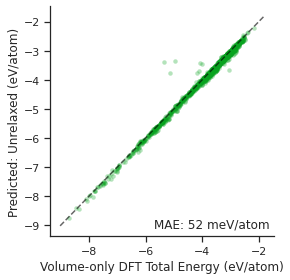

In [222]:
df = dft_data.copy()
f, (ax1) = plt.subplots(ncols=1, figsize=(4,4))

df.plot.scatter(x="vol_energyperatom", y="predicted_energy", ax=ax1,
                alpha=0.3, s=20, linewidth=0,
                # color="#c47214",  # orange
                color="#08a31f", # green
               )
ax1.plot(ax1.get_xlim(), 
         ax1.get_xlim(), 
         ls='--', c='black', alpha=0.6)

ax1.set_xlabel("Volume-only DFT Total Energy (eV/atom)")
ax1.set_ylabel("Predicted: Unrelaxed (eV/atom)")
mae = (df['vol_energyperatom'] - df["predicted_energy"]).abs().mean()
ax1.text(1, 0.025, f'MAE: {mae*1000:.0f} meV/atom ',
        ha='right', va='bottom', transform=ax1.transAxes, fontsize=12)

sns.despine()
plt.tight_layout()
out_file = f"{viz_dir}/pred_vs_dft_vol.svg"
print(os.path.abspath(out_file))
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight', dpi=300)

Text(0.5, 0, 'Predicted - Volume-only DFT Total Energy (eV/atom)')

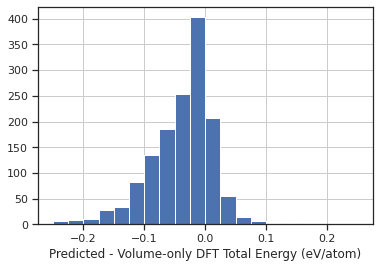

In [229]:
bins = np.arange(-0.25, 0.251, .025)
(df['predicted_energy'] - df["vol_energyperatom"]).hist(bins=bins)
plt.xlabel("Predicted - Volume-only DFT Total Energy (eV/atom)")

In [223]:
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/viz/pred_vs_dft.csv"
dft_data.to_csv(out_file)

## Compute the self-consistent decomposition energy
- The convex hulls to this point have been constructed with only the ICSD structures
- Many of high-reward compositions with a stable structure could compete with each other
- Therefore, we need to reconstruct the convex hulls with our additional data to see which compositions are truly stable

### First, use just DFT-relaxed energies to construct the convex hull

In [111]:
competing_phases_files = [
    "/projects/rlmolecule/jlaw/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv",
    # "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/best_decor_rewards.csv.gz",
]

In [120]:
competing_phases = setup_competing_phases(competing_phases_files)

Reading /projects/rlmolecule/jlaw/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv
	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4
columns after renaming: Index(['sortedformula', 'icsdnum', 'energyperatom', 'reduced_composition'], dtype='object')
	12682 entries


In [113]:
dft_data.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,predicted_energy,predicted_decomp,energy_err,comp,id,decomp_energy
id,,,,,,,,,,
K2Hf1W3N8_icsd_020114_1,K2Hf1W3N8/K2Hf1W3N8_icsd_020114_1,28,564.05,-8.203,-8.082979,-0.1975,0.120021,K2Hf1W3N8,K2Hf1W3N8_icsd_020114_1,-0.317494
Li4Y2Br8O1_icsd_002330_1,Li4Y2Br8O1/Li4Y2Br8O1_icsd_002330_1,30,781.97,-4.245,-3.923797,-0.2844,0.321203,Li4Y2Br8O1,Li4Y2Br8O1_icsd_002330_1,-0.605567


In [158]:
# Add the DFT-relaxed energies to the list of competing phases
pd_entries = dft_data.apply(
    lambda row: PDEntry(Composition(row.comp),
                        row.energyperatom * Composition(row.comp).num_atoms),
    axis=1
)
print(pd_entries.head(2))
merged_competing_phases = list(competing_phases) + list(pd_entries)
print(merged_competing_phases[-1])
print(len(merged_competing_phases))

id
K2Hf1W3N8_icsd_020114_1     PDEntry : K2 Hf1 W3 N8 with energy = -114.8420
Li4Y2Br8O1_icsd_002330_1    PDEntry : Li4 Y2 Br8 O1 with energy = -63.6750
dtype: object
PDEntry : K2 Sc2 Cl1 Br7 with energy = -47.0040
14226


In [125]:
dft_data.reset_index(drop=True, inplace=True)

In [156]:
dft_data.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,predicted_energy,predicted_decomp,energy_err,comp,decomp_energy
id,,,,,,,,,
K2Hf1W3N8_icsd_020114_1,K2Hf1W3N8/K2Hf1W3N8_icsd_020114_1,28,564.05,-8.203,-8.082979,-0.1975,0.120021,K2Hf1W3N8,-0.317494
Li4Y2Br8O1_icsd_002330_1,Li4Y2Br8O1/Li4Y2Br8O1_icsd_002330_1,30,781.97,-4.245,-3.923797,-0.2844,0.321203,Li4Y2Br8O1,-0.605567


In [159]:
# compute the self-consistent decomposition energy
def compute_reward(row):
    comp = row.comp.split('|')[0]
    combined_reward, info = rewarder.compute_reward(
        Composition(comp), row.energyperatom)
    info['reward'] = combined_reward
    return info
                            

rewarder = StructureRewardBattInterface(merged_competing_phases)

new_data = dft_data.progress_apply(compute_reward, axis=1)
new_df = pd.DataFrame(list(new_data.values))
new_df['id'] = dft_data.index
new_df.head(2)

  0%|          | 0/1486 [00:00<?, ?it/s]

,predicted_energy,oxidation,reduction,stability_window,decomp_energy,cond_ion_frac,reward,id
0,-8.203,-2.2225,-0.6439,1.5785,-0.0417,0.1429,0.369453,K2Hf1W3N8_icsd_020114_1
1,-4.245,NaN,NaN,NaN,0.1087,0.2667,0.308778,Li4Y2Br8O1_icsd_002330_1


In [163]:
new_df.rename(columns={'predicted_energy': 'energyperatom'}, inplace=True)

In [164]:
# write to file
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/self_consistent_decomp_energies/dft_only.csv"
new_df.set_index('id').to_csv(out_file)

Text(0.5, 0, 'DFT Self-consistent Decomposition Energy')

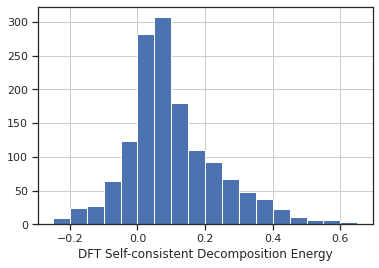

In [168]:
bins = np.arange(-.25, .7, .05)
new_df.decomp_energy.hist(bins=bins)
plt.xlabel("DFT Self-consistent Decomposition Energy")

In [169]:
print(len(new_df[new_df['decomp_energy'] < 0]))
print(len(new_df[new_df['decomp_energy'] < -.1]))

304
116


### Now include the new DFT energies as well as best prediction for each composition in the convex hull creation

In [129]:
all_decors_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/all_decor_rewards.csv.gz"
data = pd.read_csv(all_decors_file)
print(len(data))
# get the structure with the lowest predicted total energy per composition
data_comp = data.sort_values('predicted_energy').groupby('comp').agg({'id': 'first'})
# get the rows from the original df that match the id
data_best = data[data.id.isin(data_comp.id)]
print(len(data_best))
data_best.head(2)

14277451
220824


,id,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
74,Li2W1Zn1Br2I8_icsd_408052_1,Li2W1Zn1Br2I8,0.257,-2.055,0.726,0.143,NaN,NaN,NaN
146,Li4Cd1Al2O4S2_icsd_413705_4,Li4Cd1Al2O4S2,0.209,-2.595,2.782,0.308,NaN,NaN,NaN


In [142]:
# replace the predicted energy with the DFT energy if available
# dft_data.set_index('id', inplace=True)
# data_best.set_index('id', inplace=True)
data_best.loc[data_best.index.isin(dft_data.index), 'predicted_energy'] = dft_data['energyperatom']
print(len(data_best))

220824


In [143]:
data_best.loc[data_best.index.isin(dft_data.head(2).index)]

,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
id,,,,,,,,
Li4Y2Br8O1_icsd_002330_1,Li4Y2Br8O1,0.714126,-4.245,-0.2844,0.2667,-2.3734,-4.5772,2.2038
K2Hf1W3N8_icsd_020114_1,K2Hf1W3N8,0.668253,-8.203,-0.1975,0.1429,0.0000,-1.3823,1.3823


In [144]:
# now include the predicted energies in the convex hull 
def make_pd_entry(row):
    comp = Composition(row.comp)
    energy = row.predicted_energy * comp.num_atoms
    return PDEntry(comp, energy)

pred_competing_phases = list(data_best.apply(make_pd_entry, axis=1))
print(pred_competing_phases[:2])
merged_competing_phases = list(competing_phases) + pred_competing_phases
print(len(merged_competing_phases))

[PDEntry : Li2 W1 Zn1 Br2 I8 with energy = -28.7700, PDEntry : Li4 Cd1 Al2 O4 S2 with energy = -33.7350]
233564


In [149]:
# compute the self-consistent decomposition energy
def compute_reward(row):
    combined_reward, info = rewarder.compute_reward(
        Composition(row.comp), row.energyperatom)
    info['reward'] = combined_reward
    return info
                            

rewarder = StructureRewardBattInterface(merged_competing_phases)

new_data = dft_data.progress_apply(compute_reward, axis=1)
new_df = pd.DataFrame(list(new_data.values))
new_df['id'] = dft_data.index
new_df.head(2)

  0%|          | 0/1486 [00:00<?, ?it/s]

,predicted_energy,oxidation,reduction,stability_window,decomp_energy,cond_ion_frac,reward,id
0,-8.203,-2.2225,-0.6439,1.5785,-0.0417,0.1429,0.369453,K2Hf1W3N8_icsd_020114_1
1,-4.245,NaN,NaN,NaN,0.1087,0.2667,0.308778,Li4Y2Br8O1_icsd_002330_1


In [154]:
dft_data.head(2)

,decoration,numatoms,relaxedvolume,energyperatom,predicted_energy,predicted_decomp,energy_err,comp,decomp_energy
id,,,,,,,,,
K2Hf1W3N8_icsd_020114_1,K2Hf1W3N8/K2Hf1W3N8_icsd_020114_1,28,564.05,-8.203,-8.082979,-0.1975,0.120021,K2Hf1W3N8,-0.317494
Li4Y2Br8O1_icsd_002330_1,Li4Y2Br8O1/Li4Y2Br8O1_icsd_002330_1,30,781.97,-4.245,-3.923797,-0.2844,0.321203,Li4Y2Br8O1,-0.605567


In [150]:
new_df.rename(columns={'predicted_energy': 'energyperatom'}, inplace=True)

In [151]:
# write to file
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/self_consistent_decomp_energies/dft_and_all_pred.csv"
new_df.set_index('id').to_csv(out_file)

In [170]:
# write to file
in_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/self_consistent_decomp_energies/dft_and_all_pred.csv"
new_df = pd.read_csv(in_file)
new_df.head(2)

,id,energyperatom,oxidation,reduction,stability_window,decomp_energy,cond_ion_frac,reward
0,K2Hf1W3N8_icsd_020114_1,-8.203,-2.2225,-0.6439,1.5785,-0.0417,0.1429,0.369453
1,Li4Y2Br8O1_icsd_002330_1,-4.245,NaN,NaN,NaN,0.1087,0.2667,0.308778


Text(0.5, 0, 'DFT Self-consistent Decomposition Energy \n with lowest predicted energy for all compositions')

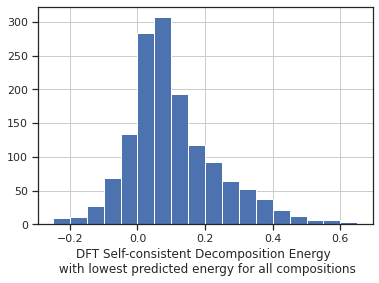

In [171]:
bins = np.arange(-.25, .7, .05)
new_df.decomp_energy.hist(bins=bins)
plt.xlabel("DFT Self-consistent Decomposition Energy \n with lowest predicted energy for all compositions")

In [172]:
print(len(new_df[new_df['decomp_energy'] < 0]))
print(len(new_df[new_df['decomp_energy'] < -.1]))

280
77


In [ ]:
len(new_df

In [106]:
rewards_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/all_self_cons_decomp_energies.csv"
pred_df2 = pd.read_csv(rewards_file)
print(len(pred_df2))
pred_df2.head(2)

2003


,predicted_energy,decomp_energy,cond_ion_frac,reward,oxidation,reduction,stability_window,decor_id
0,-3.460,0.1707,0.2143,0.298055,NaN,NaN,NaN,K3Y1Al1Br9|_1_1_3_9|hexagonal|icsd_039809|2
1,-5.484,-0.0153,0.0714,0.344104,-5.0,-5.0,0.0,Li1Sc3F8Br2|_1_2_3_8|tetragonal|icsd_067711|1


In [107]:
pred_df2['id'] = pred_df2.decor_id.apply(extract_id)
stable_ids = set(pred_df2[pred_df2.decomp_energy < 0].id)
print(len(stable_ids))

131


In [108]:
len(stable_ids - set(dft_data.id))

22

In [109]:
stable_ids - set(dft_data.id)

{'K1Cd3F1I6_icsd_095538_1',
 'K1La1Cd2I8_icsd_200869_2',
 'K1Sc3Br1I9_icsd_281588_2',
 'K1Sc3F9Br1_icsd_028012_2',
 'K1Sc3F9Cl1_icsd_028012_2',
 'K1Sc3F9I1_icsd_028012_2',
 'K2La1F1I4_icsd_428056_2',
 'Li1Al3Br9I1_icsd_018100_2',
 'Li1Al3Cl1Br9_icsd_018100_2',
 'Li1Sc2F6Br1_icsd_035428_1',
 'Li1Sc3Br9I1_icsd_018100_2',
 'Li1Sc3F1Br9_icsd_018100_2',
 'Li1Ti2F9_icsd_421958_1',
 'Li1Y3Br9I1_icsd_010384_2',
 'Na1Hf1Br5_icsd_069563_1',
 'Na1Hf2Br9_icsd_421958_1',
 'Na1Sc3Br1I9_icsd_018100_2',
 'Na1Sc3Br9I1_icsd_018100_2',
 'Na1Sc3Cl1Br9_icsd_018100_2',
 'Na1Sc3F9I1_icsd_028012_2',
 'Na1Ti2F9_icsd_084364_1',
 'Na1Zr1Br5_icsd_069563_1'}

In [20]:
from pymatgen.core import Composition

In [165]:
df[df.decor_id == "Li1Ge1O1N1|_1_1_1_1|orthorhombic|icsd_183047|2"]

,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,Unnamed: 8
787,Li1Ge1O1N1|_1_1_1_1|orthorhombic|icsd_183047|2,0.312,-6.131,0.0,0.25,NaN,NaN,NaN,NaN
